# Quick start

In [187]:
%load_ext autoreload
%autoreload 2

from py3Dinterpolations.core import GridData
from py3Dinterpolations.preprocessing import Preprocessing, reverse_preprocessing
from py3Dinterpolations.plotting import plot_downsampling
from py3Dinterpolations.model import Model3D

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data from pandas

The package is written so to be able to import data from pandas. The data must be in a pandas dataframe.

Column names could be either default ["X", "Y", "Z","V"] or custom. In the latter case, the user must specify the column names in the function call.

In [172]:
df = pd.read_csv(
    "../data/griddata_default_colnames.csv",
)
df.tail()

,Z,X,Y,ID,V
31669,-19.050,4686.534,672307.806,MIP14,705130
31670,-19.065,4686.534,672307.806,MIP14,705054
31671,-19.080,4686.534,672307.806,MIP14,706275
31672,-19.096,4686.534,672307.806,MIP14,705740
31673,-19.111,4686.534,672307.806,MIP14,758766


## GridData object

This object is designed to store the data that is being interpolated in an efficient manner. It is a wrapper around a pandas dataframe, with capability to return the equivalent numpy array for interaction with interpolation packages (eg. pyKrige, scipy)

In [173]:
gd = GridData(df)
gd.data

V
ID   X        Y          Z              
MIP9 4665.043 672282.574  0.000   166250
                         -0.015   165944
                         -0.030   166173
                         -0.046   166097
                         -0.061   166250
...                                  ...
MIP1 4618.074 672268.238 -14.966  243995
                         -14.981  241020
                         -14.996  246208
                         -15.011  244072
                         -15.027  244453

[31674 rows x 1 columns]

In [174]:
print(gd.specs.vmin, gd.specs.vmax)

0 5622272


## Preprocessing

The package offers preprocessing procedures.

- **Downsampling data**: by grouping data back blocks of fixed size (resolution) and applying the mean function to each block.
- **Normalization X,Y,Z coordinates**: normalizing the coordinates to the range [0,1] by subtracting the minimum and dividing by the maximum.
- **Standardization of V values**: standardizing the V values by subtracting the mean and dividing by the standard deviation.

### Downsampling

The downsampling procedure is implemented in the function `downsample_data`. It takes as input a pandas dataframe and the resolution of the blocks. At the moment, uses the average of the block. Can be easily customized.

### Normalization of XYZ and standardization of V

Normalizing the `XYZ` coordinates ensures that all the coordinates are within a similar range, which can help prevent one coordinate from dominating the kriging interpolation process. It is especially useful when the `XYZ` coordinates have different scales or units.

Standardizing the `V` values by centering them around 0 and giving them equal variances can help ensure that the kriging algorithm is not influenced by the absolute magnitude of `V`. This can be beneficial if the `V` values have a large range or if you want to focus more on the relative differences between `V` values rather than their absolute values.

By normalizing the XYZ coordinates and standardizing the `V` values, you align the scales of the different variables and make them more comparable, which can improve the performance of the kriging algorithm.

In [175]:
downsample_res = 0.5  # downsample solution

In [176]:
preprocessed_griddata = Preprocessing(
    gd, normalize_xyz=True, standardize_v=True, downsampling_factor=0.5
).preprocess()
preprocessed_griddata.data

V
ID   X        Y        Z                 
MIP9 0.347923 0.194902 1.000000 -0.530089
                       0.973684 -0.529953
                       0.947368 -0.531140
                       0.921053 -0.532935
                       0.894737 -0.473396
...                                   ...
MIP1 0.085040 0.000000 0.315789 -0.034761
                       0.289474 -0.129860
                       0.263158 -0.258866
                       0.236842 -0.322314
                       0.210526 -0.373528

[994 rows x 1 columns]

In [177]:
preprocessed_griddata.preprocessing_params

{'downsampling': {'resolution': 0.5},
 'normalization': {'X': {'min': 4602.880000000005, 'max': 4781.548999999999},
  'Y': {'min': 672268.2379999999, 'max': 672341.7929999996},
  'Z': {'min': -19.0, 'max': 0.0}},
 'standardization': {'mean': 457532.0136261614, 'std': 551291.6904739843}}

#### Plot comparison of data before and after downsampling 

This method allows to plot the griddata before and after the downsampling. the plot allows to assess how the downsampling affects the data, by smoothing out peaks.


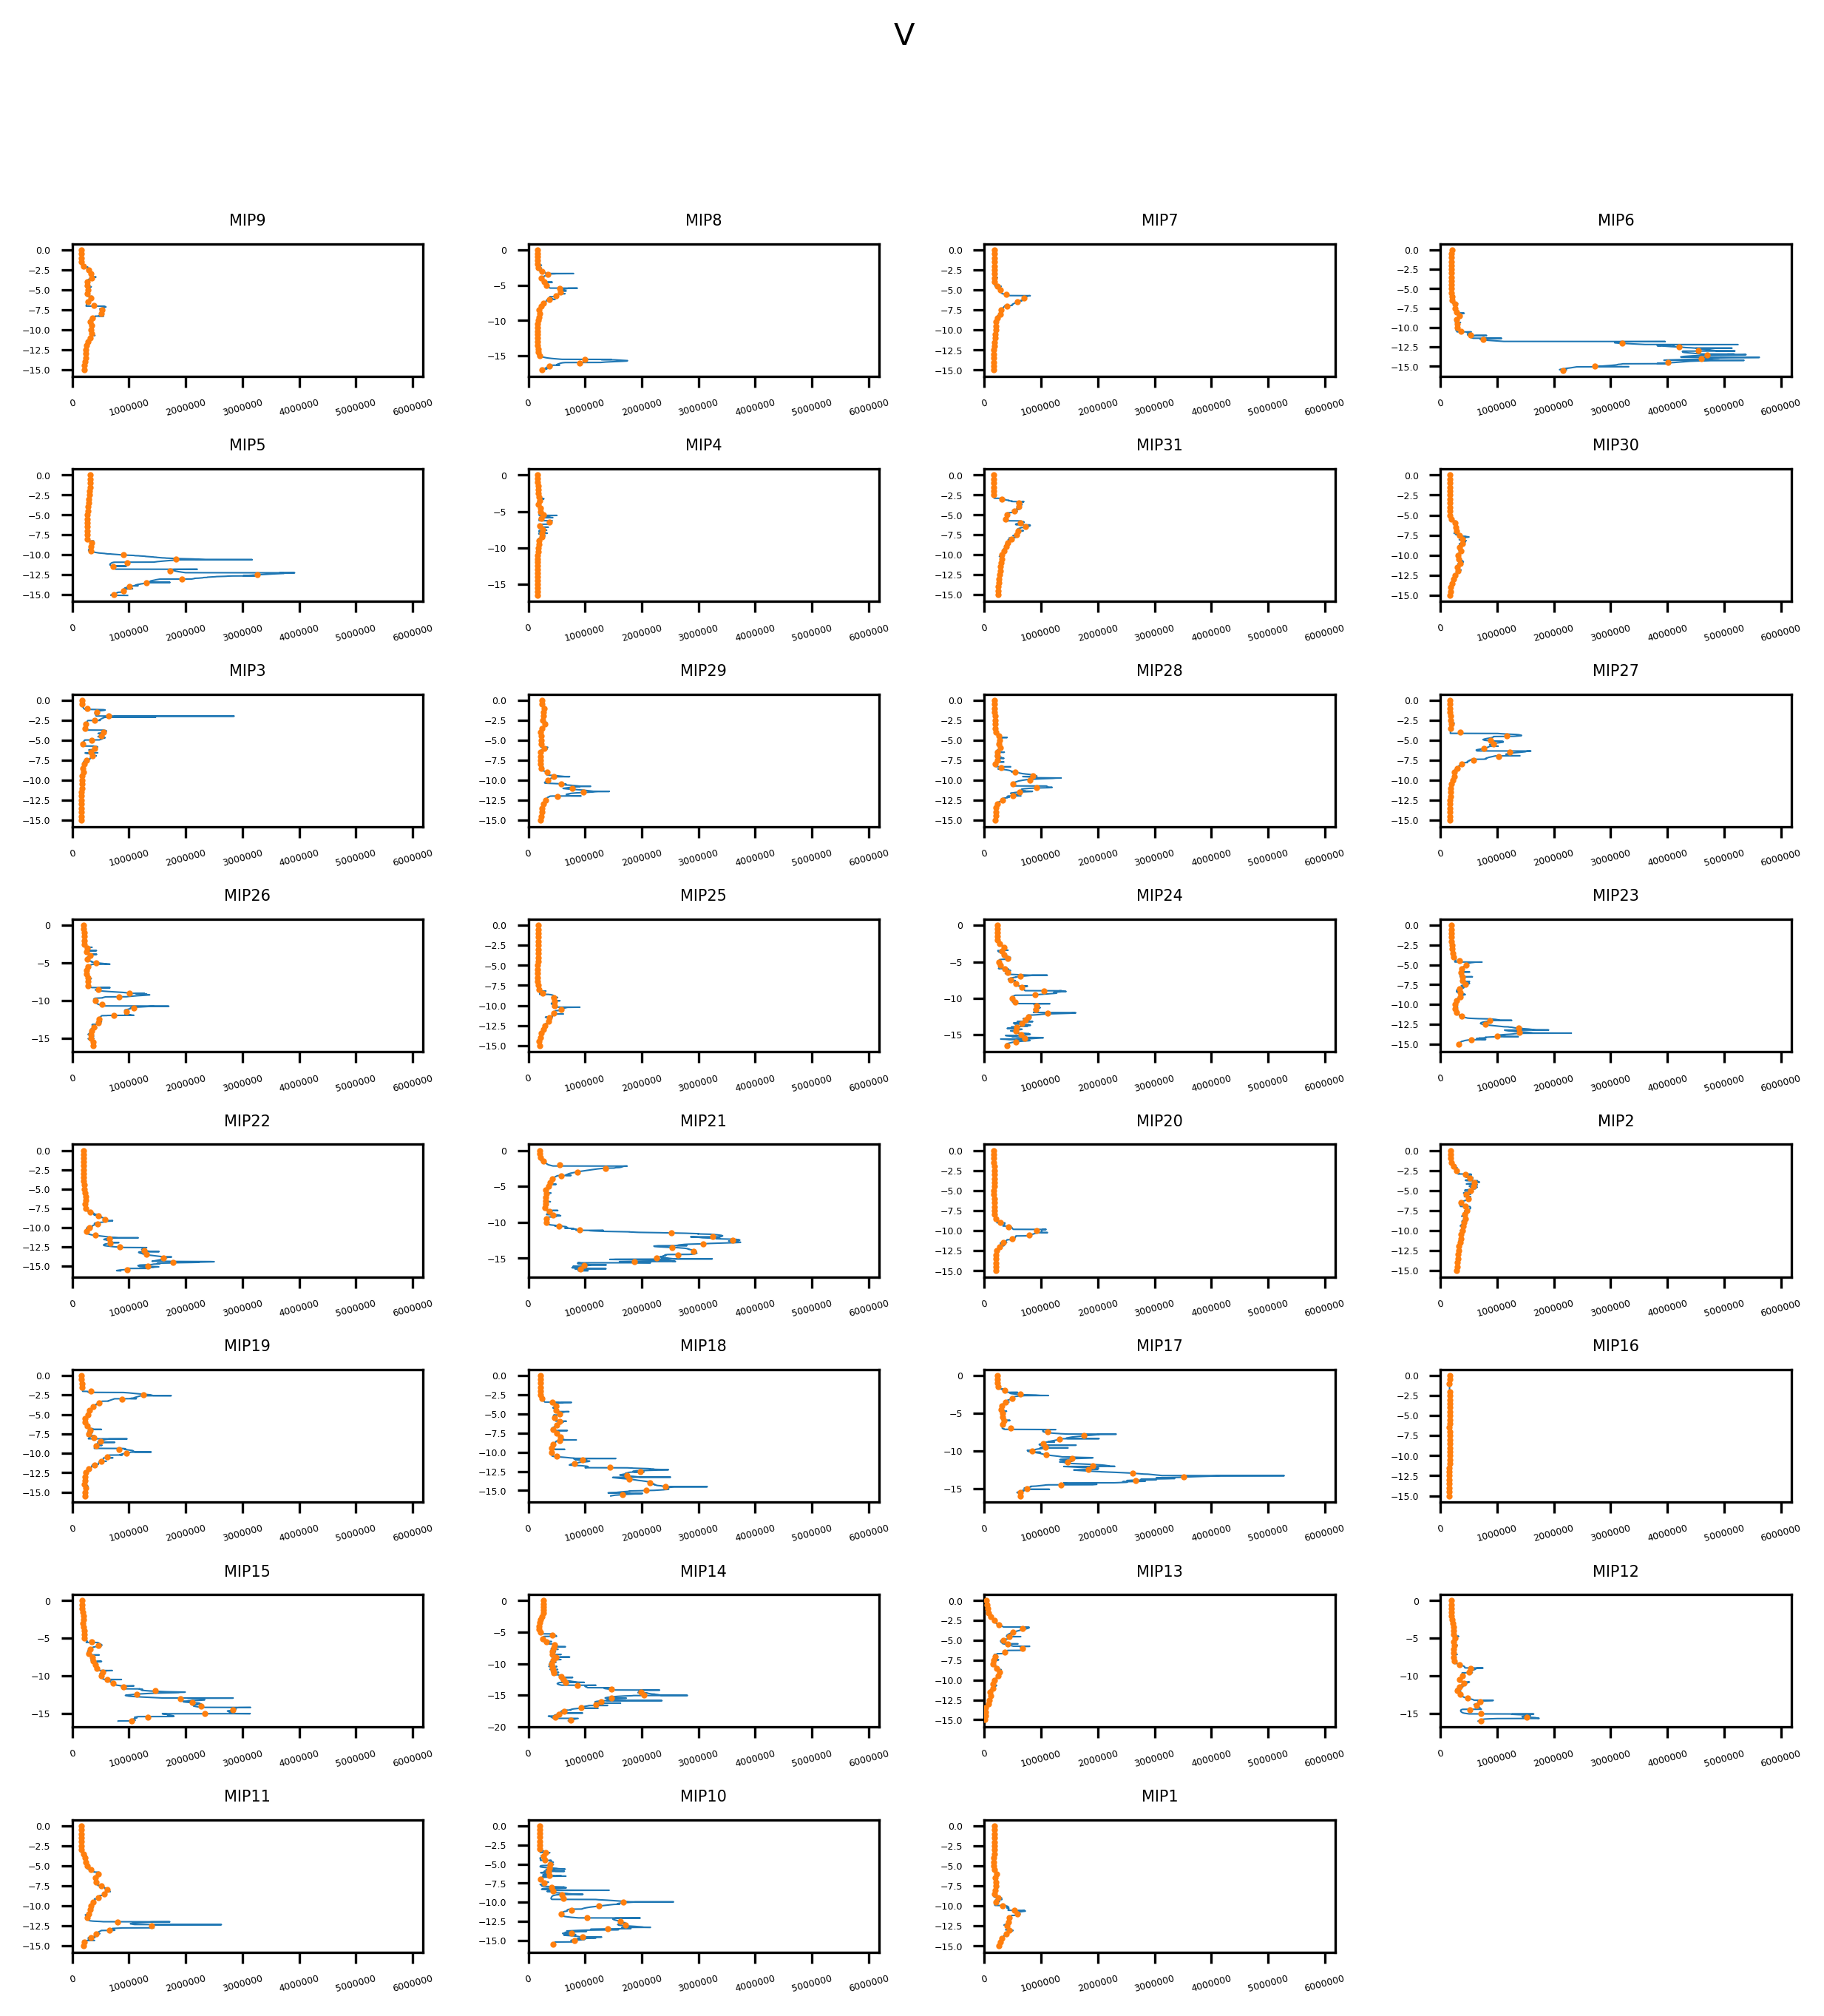

In [178]:
plot_downsampling(gd, reverse_preprocessing(preprocessed_griddata))

## Modelling

The `Modeler` class works as general wrapper for a model instance, allowing to easily switch between different models.

At the moment, the package offers the following models:
    - Ordinary Kriging (pyKrige)

In [189]:
model_params = {
    "variogram_model": "spherical",
    "nlags": 15,
    "weight": True,
    "exact_values": False,
    "verbose": True,
    "enable_plotting": True,
}

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 0.740408232053143
Full Sill: 1.1915710557512569
Range: 0.9406074732049604
Nugget: 0.45116282369811384 



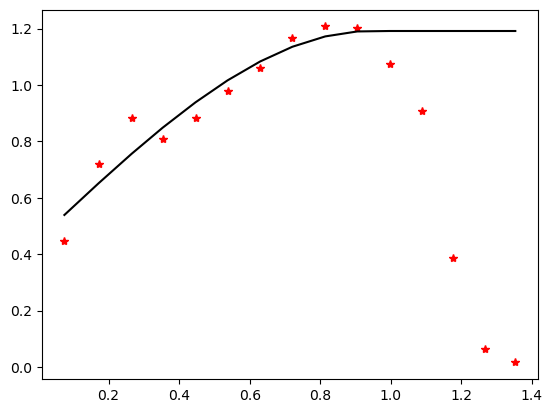

Calculating statistics on variogram model fit...
Q1 = 0.047697690226026074
Q2 = 0.7086359283779117
cR = 0.42001957201012047 



In [190]:
model = Model3D(
    preprocessed_griddata, model="ordinary_kriging", model_params=model_params
)

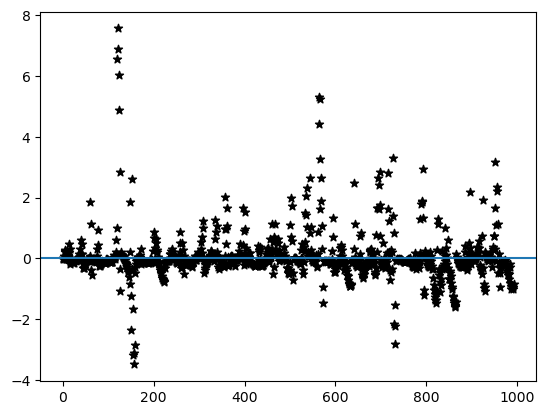

In [181]:
model.plot_model_epsilon()

In [182]:
model.predict()

Executing Ordinary Kriging...



In [185]:
model.griddata.data

V
ID   X        Y        Z                 
MIP9 0.347923 0.194902 1.000000 -0.530089
                       0.973684 -0.529953
                       0.947368 -0.531140
                       0.921053 -0.532935
                       0.894737 -0.473396
...                                   ...
MIP1 0.085040 0.000000 0.315789 -0.034761
                       0.289474 -0.129860
                       0.263158 -0.258866
                       0.236842 -0.322314
                       0.210526 -0.373528

[994 rows x 1 columns]

In [188]:
model.get_predictions()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/qd/pm08qr3s0dx5q76fd9pxjgyh0000gn/T/ipykernel_34601/2321407002.py", line 1, in <module>
    model.get_predictions()
  File "/Users/giorgiocaizzi/Documents/GitHub/py3Dinterpolations/py3Dinterpolations/model.py", line 89, in get_predictions
    and self.griddata.preprocessing_params["standardization"]
TypeError: unhashable type: 'dict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return Formatt